In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd '../HOTS'

/home/antoine/homhots/HOTS/HOTS


In [2]:
import os
import pickle
import datetime
from mix_Network import *

dataset = 'nmnist'
records_path = '../Records'
timestr = datetime.datetime.now().date().isoformat()
timestr = '2021-01-27'
verbose = True

%mkdir -p ../Records
%mkdir -p ../Records/EXP_03_NMNIST

homeo = True
sigma = None
pooling = False
homeinv = False
jitter = False
tau = 5
krnlinit = 'first'
nblay = 3
nbclust = 4

ds = 75
nb_train = 7500//ds
nb_test = 2500//ds

In [3]:
import time
def tic():
    global ttic
    ttic = time.time()
def toc():
    print(f'Done in {time.time() - ttic:.3f} s')

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type("torch.DoubleTensor") # -> torch.tensor([1.2, 3]).dtype = torch.float64
criterion = torch.nn.NLLLoss(reduction="mean") # loss divided by output size
# https://sebastianraschka.com/faq/docs/pytorch-crossentropy.html
class LogisticRegressionModel(torch.nn.Module):
    #torch.nn.Module -> Base class for all neural network modules
    def __init__(self, N, n_classes, bias=True):
        super(LogisticRegressionModel, self).__init__() 
        self.linear = torch.nn.Linear(N, n_classes, bias=bias)
        self.nl = torch.nn.LogSoftmax(dim=1)

    def forward(self, factors):
        return self.nl(self.linear(factors))

In [5]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 256
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_raw_data(dataset, 
            nb_digit,
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, #**kwargs
        ):
    
    learningset = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=True,
                                    transform=tonic.transforms.AERtoVector())
    loader = tonic.datasets.DataLoader(learningset, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device -> {device}')

    N = 34*34*2
    n_classes = 10
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    
    for epoch in range(int(num_epochs)):
        losses = []
        for i in range(nb_digit):
            X_, labels_ = next(iter(loader))
            X_, labels_ = X_.to(device), labels_.to(device)
            outputs = logistic_model(X_)
            #target = torch.argmax(torch.squeeze(labels_,dim=1), 1)
            loss = criterion(outputs, torch.nn.functional.one_hot(labels_, num_classes=n_classes))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")
            
    return logistic_model, losses

In [ ]:
tic()
model, loss = fit_raw_data(dataset, 
            nb_train,
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=True,
        )
toc()

Using downloaded and verified file: ../Data/nmnist_train.zip
Extracting ../Data/nmnist_train.zip to ../Data/
device -> cuda
Iteration: 0 - Loss: 2.98982
Iteration: 16 - Loss: 0.97457
Iteration: 32 - Loss: 0.74306
Iteration: 48 - Loss: 0.68766
Iteration: 64 - Loss: 0.57917
Iteration: 80 - Loss: 0.56238
Iteration: 96 - Loss: 0.54971
Iteration: 112 - Loss: 0.51073
Iteration: 128 - Loss: 0.48630
Iteration: 144 - Loss: 0.45520
Iteration: 160 - Loss: 0.43672
Iteration: 176 - Loss: 0.43163
Iteration: 192 - Loss: 0.42148


In [ ]:
def predict_data(model, # gamma=gamma,
            verbose=False, **kwargs
        ):
    
    learningset = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=False,
                                    transform=tonic.transforms.AERtoVector())
    loader = tonic.datasets.DataLoader(learningset, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    X, label = next(iter(loader))
    logistic_model = model.to(device)
    X = X.to(device)
    
    outputs = logistic_model(X)

    pred_target.append(torch.argmax(outputs, dim=1).item())

    return pred_target, outputs

In [ ]:
pred, output = predict_data(model)

# Testing tonic functional aer_to_vect()

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/
digit -> 1


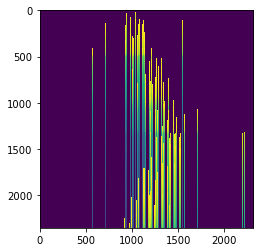

In [14]:
import tonic
import matplotlib.pyplot as plt
import torch
learningset = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=False,
                                    transform=tonic.transforms.AERtoVector())
loader = tonic.datasets.DataLoader(learningset, shuffle=True)
    
events, target = next(iter(loader))
print(f'digit -> {target.item()}')
plt.imshow(torch.squeeze(events, dim=0));

# Using batches

Pour le moment c'est trop long, l'idée était de regrouper différents digits, de faire un shuffle pour que le fit ne se fasse pas sur tout les events d'un digit, puis tous les events de l'autre etc... C'est l'idée du batch mais du coup ça fait des gros batch (environ 4000 x nb_digit au lieu de 256). Je sais pas encore comment faire de petits batchs avec différents digits tout en utilisant le dataloader.  

In [5]:
learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 32
n_classes=10
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_raw_data(dataset, 
            nb_digit,
            learning_rate=learning_rate,
            batch_size=batch_size,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=False, #**kwargs
        ):
    
    learningset = tonic.datasets.NMNIST(save_to='../Data/',
                                    train=False,
                                    transform=tonic.transforms.AERtoVector())
    loader = tonic.datasets.DataLoader(learningset, shuffle=True)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f'device -> {device}')

    N = 34*34*2
    n_classes = 10
    logistic_model = LogisticRegressionModel(N, n_classes)
    logistic_model = logistic_model.to(device)
    logistic_model.train()
    optimizer = torch.optim.Adam(
        logistic_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    
    for epoch in range(int(num_epochs)):
        losses = []
        for n_batch in range(nb_digit//batch_size):
            X_ = torch.zeros(1,1,N)
            labels_ = torch.tensor([])
            for n_dig in range(batch_size):
                x, l = next(iter(loader))
                X_ = torch.cat([X_,x],dim=1)
                l = torch.ones([x.shape[1]])*l
                labels_ = torch.cat([labels_,l])
            X_ = X_[:,1:,:]
            X_, labels_ = X_.to(device), labels_.to(device)
            rid = torch.randperm(X_.shape[1])
            X_ = X_[:,rid,:]
            labels_ = labels_[rid]
            outputs = logistic_model(X_)
            #target = torch.argmax(torch.squeeze(labels_,dim=1), 1)
            #loss = criterion(torch.squeeze(outputs), torch.nn.functional.one_hot(labels_.long(), num_classes=n_classes))
            loss = criterion(torch.squeeze(outputs), labels_.long())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")
            
    return logistic_model, losses

In [6]:
tic()
model, loss = fit_raw_data(dataset, 
            nb_train,
            learning_rate=learning_rate,
            batch_size=32,  # gamma=gamma,
            num_epochs=num_epochs,
            betas=betas,
            verbose=True,
        )
toc()

Using downloaded and verified file: ../Data/nmnist_test.zip
Extracting ../Data/nmnist_test.zip to ../Data/
device -> cuda
Iteration: 0 - Loss: 11.56868
Iteration: 16 - Loss: 10.67493
Iteration: 32 - Loss: 10.63004
Iteration: 48 - Loss: 10.46134
Iteration: 64 - Loss: 10.58107
Iteration: 80 - Loss: 10.70146
Iteration: 96 - Loss: 10.42048
Iteration: 112 - Loss: 10.47929
Iteration: 128 - Loss: 10.35275
Iteration: 144 - Loss: 10.35640
Iteration: 160 - Loss: 10.39479
Iteration: 176 - Loss: 10.52240
Iteration: 192 - Loss: 10.38457
Iteration: 208 - Loss: 10.38800


KeyboardInterrupt: 